# Importing the required packages

In [17]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore', '.*do not.*',)

In [2]:
# plate size, m
w = h = 0.010
# intervals in x-, y- directions, mm
dx = dy = 0.0002
# Thermal diffusivity of steel, mm2.s-1
K = 4.*0.001*0.001
rho=1.0
cp=1.0
Tcool, Thot = 300, 700
nsteps = 20000

In [3]:
nx, ny = int(w/dx), int(h/dy)
dx2, dy2 = dx*dx, dy*dy
dt = dx2 * dy2 / (2 * K * (dx2 + dy2)/rho/cp)
T0 = Tcool * np.ones((nx, ny))
T = np.empty((nx, ny))
q = np.zeros((nx, ny))

In [4]:
def init_circ(T0):
    # Initial conditions - ring of inner radius r, width dr centred at (cx,cy) (mm)
    r, cx, cy = 0.002, 0.005, 0.005
    r2 = r**2
    for i in range(nx):
        for j in range(ny):
            p2 = (i*dx-cx)**2 + (j*dy-cy)**2
            if p2 < r2:
                T0[i,j] = Thot
    return T0

In [5]:
def init_square(T0):
    dl,cx,cy=0.002,0.005,0.005
    for i in range(nx):
        for j in range(ny):
            if (i*dx > cx-dl) and (i*dx < cx+dl) and (j*dy > cy-dl) and (j*dy <cy+dl):
                T0[i,j]=Thot
    return T0

In [6]:
def do_timestep(T0, T):
    # Propagate with forward-difference in time, central-difference in space
    T[1:-1, 1:-1] = T0[1:-1, 1:-1] + (K * dt/rho/cp) * (
          (T0[2:, 1:-1] - 2*T0[1:-1, 1:-1] + T0[:-2, 1:-1])/dx2
          + (T0[1:-1, 2:] - 2*T0[1:-1, 1:-1] + T0[1:-1, :-2])/dy2 ) +q[1:-1,1:-1]*(dt/rho/cp)

    T0 = T.copy()
    return T0, T

# Solve the equations to generate the temperature field

In [7]:
X=np.zeros((nsteps,nx,ny))
T0=init_square(T0)
for m in range(nsteps):
    T0, T = do_timestep(T0, T)
    X[m,:,:]=T[:,:]

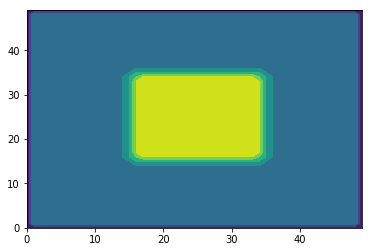

In [8]:
plt.contourf(X[0,:,:])
plt.show()

# Preparing data for training

In [9]:
X_train=np.reshape(X, (len(X), nx, ny, 1))

In [10]:
# We want to predict the temperature field at time "n+1" using the temperature field at time "n"
X1_train=X_train[0:len(X_train)-1,:,:,:]
y1_train=X_train[1:len(X_train),:,:,:]

In [18]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
input_img = Input(shape=(nx, ny, 1))
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu',padding='same')(x)
decoded = Conv2D(1, (3, 3), activation='linear', padding='same')(x)
autoencoder = Model(input_img, decoded)
autoencoder.compile(loss='mean_squared_error', optimizer='adam')

In [12]:
autoencoder.fit(X1_train, y1_train,epochs=100,batch_size=500)

Epoch 1/100
19999/19999 [==============================] - 8s 401us/step - loss: 333.5329
Epoch 2/100
19999/19999 [==============================] - 4s 201us/step - loss: 2.7640
Epoch 3/100
19999/19999 [==============================] - 4s 202us/step - loss: 0.6712
Epoch 4/100
19999/19999 [==============================] - 4s 201us/step - loss: 0.3725 2s - loss: 0 
Epoch 5/100
19999/19999 [==============================] - 4s 202us/step - loss: 0.2081
Epoch 6/100
19999/19999 [==============================] - 4s 202us/step - loss: 0.1398
Epoch 7/100
19999/19999 [==============================] - 4s 201us/step - loss: 0.1069
Epoch 8/100
19999/19999 [==============================] - 4s 203us/step - loss: 0.0865
Epoch 9/100
19999/19999 [==============================] - 4s 202us/step - loss: 0.0728
Epoch 10/100
19999/19999 [==============================] - 4s 203us/step - loss: 0.0885
Epoch 11/100
19999/19999 [==============================] - 4s 203us/step - loss: 0.0680
Epoch 12/100
1

19999/19999 [==============================] - 4s 208us/step - loss: 0.0237
Epoch 93/100
19999/19999 [==============================] - 4s 210us/step - loss: 0.0271
Epoch 94/100
19999/19999 [==============================] - 4s 207us/step - loss: 0.0178
Epoch 95/100
19999/19999 [==============================] - 4s 208us/step - loss: 0.0149
Epoch 96/100
19999/19999 [==============================] - 4s 210us/step - loss: 0.0140
Epoch 97/100
19999/19999 [==============================] - 4s 214us/step - loss: 0.0128
Epoch 98/100
19999/19999 [==============================] - 4s 211us/step - loss: 0.0116
Epoch 99/100
19999/19999 [==============================] - 4s 212us/step - loss: 0.0113
Epoch 100/100
19999/19999 [==============================] - 4s 209us/step - loss: 0.0102


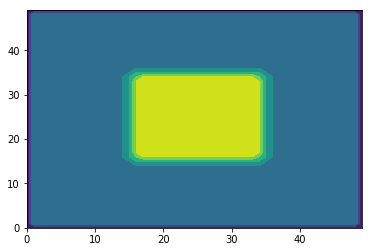

In [13]:
plt.contourf(X1_train[0,:,:,0])
plt.show()

# Make the predictions using CNN

In [14]:
xtest=X1_train[0,:,:,0]
xtest=np.reshape(xtest,(1,nx,ny,1))
Xconv=np.zeros((nsteps,nx,ny))
for m in range(nsteps):
    xtest=autoencoder.predict(xtest)
    Xconv[m,:,:]=xtest[0,:,:,0]

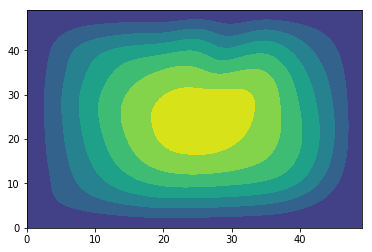

In [15]:
plt.contourf(Xconv[200,:,:])
plt.show()

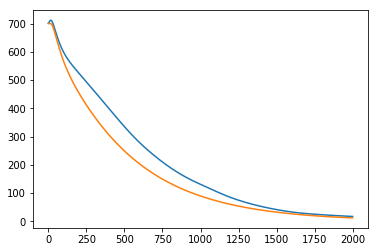

In [16]:
plt.plot(Xconv[0:2000,25,25])
plt.plot(X1_train[0:2000,25,25,0])
plt.show()